In [1]:
import pandas as pd
from transformers import pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef
import matplotlib.pyplot as plt

In [38]:
# Load pre-trained model
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions")

# Load email dataset from CSV
df = pd.read_csv("./100_emotion_emails.csv", delimiter=';')

# Optional: Drop rows where 'emotion' is NaN or empty
df = df.dropna(subset=['emotion'])
df = df[df['emotion'].str.strip() != '']
print(df['text'])

emails = df['text'].tolist()
labels = set(df['emotion'].tolist())

# Open the output file in write mode
with open('output.txt', 'w') as f:
    # Write all the texts (emails)
    for text in emails:
        f.write(text + '\n')

    # Write a separator to indicate the start of emotions
    f.write('\n---EMOTIONS---\n') 

    # Write all the unique emotions
    for label in labels:
        f.write(label + '\n') 

0      Dear user, we've detected unauthorized access ...
1      We've noticed a suspicious login attempt from ...
2      Our systems have detected unusual activity on ...
3      Be advised that we've identified an attempt to...
4      Our security system has flagged your account f...
                             ...                        
100    Congratulations! You've been selected for an e...
101    We've noticed some unusual activity on your ac...
102    Unexpected account activity alert: You've rece...
103    As a token of our appreciation for your contin...
104    After recent security breaches, we're offering...
Name: text, Length: 105, dtype: object


In [39]:
# Classify emotions
results = []
for email in emails:
    model_output = classifier(email, top_k=1)  # Ensure we get the top prediction
    results.append(model_output[0]['label'])  # Store only the label for simplicity

# Add predicted emotions to the dataframe
df['predicted_emotion'] = results

# Ensure all emotion labels are strings
df['emotion'] = df['emotion'].astype(str)
df['predicted_emotion'] = df['predicted_emotion'].astype(str)

true_labels = df['emotion'].str.strip()
predicted_labels = df['predicted_emotion']
labels = pd.unique(true_labels)  # Get unique labels from your dataset

In [40]:
# Calculate precision, recall, F1-score using 'macro' average
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro', labels=pd.unique(true_labels), zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='macro', labels=pd.unique(true_labels), zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='macro', labels=pd.unique(true_labels), zero_division=0)

print("Overall Metrics (macro):")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

Overall Metrics (macro):
Accuracy: 0.371
Precision: 0.470
Recall: 0.372
F1-Score: 0.385


In [23]:
def calc_label_metrics(label, y_targets, y_preds):
    # Filter out the instances for the current label
    is_label = y_targets == label
    y_targets_binary = is_label.astype(int)  # Convert to binary (1 for current label, 0 for all others)
    y_preds_binary = (y_preds == label).astype(int)
    
    return {
        "label": label,
        "precision": precision_score(y_targets_binary, y_preds_binary, zero_division=0),
        "recall": recall_score(y_targets_binary, y_preds_binary, zero_division=0),
        "f1": f1_score(y_targets_binary, y_preds_binary, zero_division=0),
        "mcc": matthews_corrcoef(y_targets_binary, y_preds_binary),
        "support": is_label.sum()
    }

results = []
for label in labels:
    results.append(calc_label_metrics(label, true_labels, predicted_labels))

per_label_results = pd.DataFrame(results)
per_label_results.set_index("label", inplace=True)
display(per_label_results.round(3))
print(true_labels)
print(predicted_labels)

,precision,recall,f1,mcc,support
label,,,,,
fear,0.000,0.000,0.000,0.000,17
curiosity,0.714,0.500,0.588,0.564,10
excitement,0.571,0.400,0.471,0.434,10
confusion,1.000,0.667,0.800,0.795,15
caring,0.600,0.600,0.600,0.558,10
admiration,0.556,1.000,0.714,0.730,5
anger,0.000,0.000,0.000,0.000,5
joy,1.000,0.400,0.571,0.623,5
sadness,1.000,0.400,0.571,0.623,5


0           fear
1           fear
2           fear
3           fear
4           fear
         ...    
100       desire
101         fear
102     surprise
103    gratitude
104       relief
Name: emotion, Length: 105, dtype: object
0        neutral
1      curiosity
2        neutral
3         caring
4        neutral
         ...    
100    gratitude
101      neutral
102     surprise
103    gratitude
104    gratitude
Name: predicted_emotion, Length: 105, dtype: object


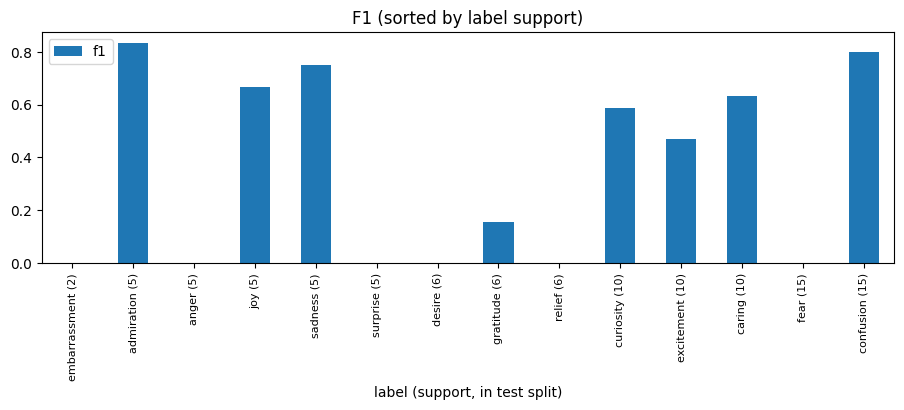

In [6]:
per_label_results["label (support)"] = (
    per_label_results.index + " (" + per_label_results["support"].astype(str) + ")"
)
ax = per_label_results.sort_values(by="support").plot.bar(
    x="label (support)",
    y=["f1"],
    rot=90,
    title="F1 (sorted by label support)",
    figsize=(11,3),
)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.axes.xaxis.label.set_text(f"label (support, in test split)")
plt.show()

### Initial Observations:
- **Overall Metrics:** The macro-averaged precision, recall, and F1 score are quite low. This suggests that the model isn't generalizing well across all emotions in the email dataset.
- **Performance by Emotion:** There is a significant variance in performance across different emotions. Some emotions like confusion, admiration, and sadness are detected with high precision and F1 scores, while others like fear, anger, desire, and surprise have zero scores across all metrics.
- **Support Issues:** The number of samples (support) for each emotion greatly varies. Some emotions with fewer samples (like embarrassment with only 2) might not have enough data to allow the model to learn effectively.

### Interpretation of Results:
- **High Variance:** The high variance in F1 scores between emotions suggests that the model is not yet robust enough to handle the range of emotions in your emails.
- **Zero Scores:** The zero scores for certain emotions indicate that the model might not have learned features to identify these emotions, or these emotions are not represented similarly in email data as they are in Reddit data.
- **Matthews Correlation Coefficient (MCC):** The MCC is a balanced measure that can be used even if the classes are of very different sizes. Some labels with high MCC suggest that the model does have the capability to generalize, at least for certain emotions.

### Actions Based on the Results:
- **Imbalanced Data Handling:** The imbalance in the dataset could be a major issue. Techniques like resampling, synthetic data generation, or class weighting during training could help address this.
- **Expand Dataset:** Increasing the number of labeled examples, especially for emotions that the model is currently not recognizing at all, could provide more data for the model to learn from.
- **Model Complexity:** If the model is too simple, it might not capture the complexity of emotions in emails. Conversely, if it's too complex, it might overfit on the Reddit data and not generalize well.
- **Domain Adaptation:** Employ domain adaptation techniques to adjust the model to the email domain. This could involve fine-tuning the model with a representative set of email data.